# Customer Analysis
In this section, we seek to address the challenge of competition from other businesses. Hence, we aim to find method to allow Tasty Bytes to stand out as a superior option via understand the consumption patterns of its existing customers.

Some of our end goals are as follows:
- Understand customer purchase behaviours
- Segment customers --> provide more relevant/ personalized offers

These goals will ultimately lead to the growth of Tasty Bytes' revenue

In [1]:
#import libs
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing
import sklearn

import sys
import getpass
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import tree

from math import sqrt
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_columns', None)

In [2]:
accountname = getpass.getpass('Enter account name')  #zu99035.ap-southeast-1

Enter account name ········


In [3]:
username = getpass.getpass('Enter username') #Model

Enter username ········


In [4]:
password = getpass.getpass('Enter password') #Password1

Enter password ········


In [5]:
#login credentials
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "SYSADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": "COMPUTE_WH",
    "schema": "RAW_POS"
}

session = Session.builder.configs(connection_parameters).create()

In [6]:
#create snowflake dataframe
order_detail_sdf = session.table('ORDER_DETAIL')
order_header_sdf = session.table('ORDER_HEADER')
location_sdf = session.table('LOCATION')
menu_sdf = session.table('MENU')

In [7]:
#join order information
full_order_sdf = order_detail_sdf.join(order_header_sdf, "ORDER_ID")
full_order_sdf.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"ORDER_DETAIL_ID"  |"MENU_ITEM_ID"  |"l_svaq_DISCOUNT_ID"  |"LINE_NUMBER"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"r_sj5o_DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
------------------------------------------------------------------------------------------------------------------------------------

In [8]:
full_order_sdf.count()

673655465

In [9]:
#each reciept with location details
order_location_sdf = order_header_sdf.join(location_sdf, "LOCATION_ID")

In [10]:
order_location_sdf.count()

248201269

In [11]:
order_location_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"ORDER_ID"  |"TRUCK_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"PLACEKEY"           |"LOCATION"         |"CITY"  |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
#remove duplicate column
full_order_sdf = full_order_sdf.drop('r_ejvd_DISCOUNT_ID')

In [13]:
order_header_sdf.describe().to_pandas()

,SUMMARY,ORDER_ID,TRUCK_ID,LOCATION_ID,CUSTOMER_ID,DISCOUNT_ID,SHIFT_ID,ORDER_CHANNEL,SERVED_TS,ORDER_CURRENCY,ORDER_AMOUNT,ORDER_TAX_AMOUNT,ORDER_DISCOUNT_AMOUNT,ORDER_TOTAL
0,max,4.595204e+08,4.500000e+02,1.551700e+04,2.225400e+05,None,2.005832e+08,None,None,USD,7.530000e+02,None,None,7.530000e+02
1,count,2.482013e+08,2.482013e+08,2.482013e+08,1.336398e+07,0,2.482013e+08,0,0,248201269,2.482013e+08,0,0,2.482013e+08
2,stddev,1.660139e+08,1.175518e+02,3.773165e+03,6.604184e+04,None,1.000566e+08,None,None,None,2.972697e+01,None,None,2.972697e+01
3,min,4.063758e+06,1.000000e+00,1.001000e+03,1.000000e+00,None,2.120200e+04,None,None,USD,2.000000e+00,None,None,2.000000e+00
4,mean,2.316775e+08,2.519254e+02,8.435850e+03,1.115881e+05,None,9.687235e+07,None,None,None,4.073637e+01,None,None,4.073637e+01


In [14]:
#order groupby location
country_summary = order_location_sdf.group_by(['COUNTRY']).agg([F.avg('ORDER_TOTAL').as_('AVG_ORDER_AMT')])
country_summary.limit(10).to_pandas()

,COUNTRY,AVG_ORDER_AMT
0,Brazil,40.6506514511
1,Canada,40.1494896760
2,Australia,41.4899405211
3,Poland,40.5227691751
4,South Korea,40.4383552627
5,Japan,39.6123807005
6,Germany,42.0246378956
7,Sweden,41.9886186928
8,Spain,39.9903747052
9,England,41.9721442540


In [15]:
#utilising timestamp variable
order_location_sdf.groupBy(F.hour("ORDER_TS")).agg([F.sum('ORDER_TOTAL')]).show()

-----------------------------------------
|"HOUR(ORDER_TS)"  |"SUM(ORDER_TOTAL)"  |
-----------------------------------------
|14                |205897597.5000      |
|19                |907786456.5000      |
|10                |696081450.7500      |
|23                |16940.7500          |
|9                 |845468226.0000      |
|13                |773375214.0000      |
|16                |627340152.5000      |
|20                |894030905.5000      |
|15                |367384968.7500      |
|17                |815956959.0000      |
-----------------------------------------



### Data Preperation

In [16]:
#find variables in columns that seem to have a lot of null values
print(order_location_sdf.select('ORDER_CHANNEL').distinct().collect())
print(order_location_sdf.select('ORDER_TAX_AMOUNT').distinct().collect())
print(order_location_sdf.select('ORDER_DISCOUNT_AMOUNT').distinct().collect())

[Row(ORDER_CHANNEL=None)]
[Row(ORDER_TAX_AMOUNT=None)]
[Row(ORDER_DISCOUNT_AMOUNT=None)]


In [17]:
order_location_sdf = order_location_sdf.drop('DISCOUNT_ID','SERVED_TS','PLACEKEY','ORDER_CHANNEL','ORDER_TAX_AMOUNT','ORDER_DISCOUNT_AMOUNT')

In [18]:
order_location_sdf.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"ORDER_ID"  |"TRUCK_ID"  |"CUSTOMER_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_TS"           |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TOTAL"  |"LOCATION"         |"CITY"  |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|11823.0        |369186517   |339         |NULL           |200372773   |15:30:00            |22:30:00          |2021-05-12 18:24:46  |USD               |11.0000         |11.0000        |Kinderyoga Angela  |Munich  |Bayer

### Modelling

In [19]:
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration,owner_role_type
0,2023-07-02 23:24:49.725000-07:00,MODEL_STAGE,FROSTBYTE_TASTY_BYTES,RAW_POS,,N,N,SYSADMIN,,None,INTERNAL,None,None,None,ROLE


##### RFM

In [20]:
#filter by country
order_location_sdf_usa = order_location_sdf.filter(F.col("COUNTRY") == 'United States')
print(order_location_sdf_usa.select('COUNTRY').distinct().collect())
print(order_location_sdf_usa.count())

[Row(COUNTRY='United States')]
24079624


In [21]:
#get only rows with CUSTOMER_ID
order_location_sdf_usa = order_location_sdf_usa.na.drop(subset=["CUSTOMER_ID"])

print(order_location_sdf_usa.count())
order_location_sdf_usa.show()

2509753
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"ORDER_ID"  |"TRUCK_ID"  |"CUSTOMER_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_TS"           |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TOTAL"  |"LOCATION"              |"CITY"   |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"      |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|3645.0         |456154745   |40          |117582         |200564574   |08:30:00            |14:30:00          |2022-10-06 10:34:22  |USD               |10.0000         |10.0000     

In [22]:
# Lastest purchase date
us_recency = order_location_sdf_usa.groupBy("CUSTOMER_ID").agg([F.max('ORDER_TS').alias('most_recent_ts')])
us_recency.show()

---------------------------------------
|"CUSTOMER_ID"  |"MOST_RECENT_TS"     |
---------------------------------------
|107450         |2022-10-10 22:21:09  |
|102172         |2022-10-20 09:19:33  |
|187954         |2022-10-28 08:06:30  |
|95151          |2022-10-31 18:40:57  |
|131502         |2022-09-15 21:38:06  |
|33951          |2022-10-30 19:52:04  |
|133872         |2022-11-01 18:28:42  |
|70315          |2022-10-28 17:45:08  |
|38931          |2022-10-15 20:18:50  |
|158518         |2022-10-28 15:10:55  |
---------------------------------------



In [23]:
# Frequency
us_frequency = order_location_sdf_usa.groupBy("CUSTOMER_ID").agg([F.count('ORDER_ID').alias('frequency')])
print("Number of unique customers: {}".format(us_frequency.count()))
us_frequency.sort(us_frequency.frequency.desc()).show()

Number of unique customers: 46300
-------------------------------
|"CUSTOMER_ID"  |"FREQUENCY"  |
-------------------------------
|185279         |94           |
|166039         |92           |
|52567          |92           |
|161808         |90           |
|134184         |89           |
|139005         |88           |
|36732          |88           |
|94975          |87           |
|106132         |87           |
|91073          |86           |
-------------------------------



In [24]:
# Monetary Value
us_money = order_location_sdf_usa.groupBy("CUSTOMER_ID").agg([F.sum('ORDER_AMOUNT').alias('monetary_value')])
us_money.sort(us_money.monetary_value.desc()).show()

------------------------------------
|"CUSTOMER_ID"  |"MONETARY_VALUE"  |
------------------------------------
|153918         |4242.0000         |
|134184         |4222.2500         |
|185279         |4060.7500         |
|155126         |4052.5000         |
|24317          |3944.2500         |
|187888         |3889.0000         |
|44841          |3877.7500         |
|62668          |3876.7500         |
|55828          |3867.7500         |
|72457          |3866.5000         |
------------------------------------



In [25]:
#Converting to pandas dataframe
us_recency = us_recency.to_pandas()
us_money = us_money.to_pandas()
us_frequency = us_frequency.to_pandas()

In [26]:
# Merging the 3 dataframes based on customer id
us_rfm = us_recency.merge(us_frequency, on = 'CUSTOMER_ID', how = 'inner').merge(us_money, on = 'CUSTOMER_ID', how = 'inner')
print(us_rfm.count())
print(us_rfm.head())

CUSTOMER_ID       46300
MOST_RECENT_TS    46300
FREQUENCY         46300
MONETARY_VALUE    46300
dtype: int64
   CUSTOMER_ID      MOST_RECENT_TS  FREQUENCY  MONETARY_VALUE
0        87781 2022-10-06 18:46:47         46         1795.25
1       145829 2022-10-26 08:59:57         60         2411.75
2       158289 2022-10-06 21:05:24         72         2454.50
3       151268 2022-10-30 09:40:52         67         2678.00
4       150953 2022-10-23 21:19:08         68         2392.50


In [27]:
recent_date = us_rfm['MOST_RECENT_TS'].max()
us_rfm['Recency'] = us_rfm['MOST_RECENT_TS'].apply(
    lambda x: (recent_date - x).days)
us_rfm.head()

,CUSTOMER_ID,MOST_RECENT_TS,FREQUENCY,MONETARY_VALUE,Recency
0,87781,2022-10-06 18:46:47,46,1795.25,26
1,145829,2022-10-26 08:59:57,60,2411.75,6
2,158289,2022-10-06 21:05:24,72,2454.50,26
3,151268,2022-10-30 09:40:52,67,2678.00,2
4,150953,2022-10-23 21:19:08,68,2392.50,9


In [28]:
# cleaning the dataframe
us_rfm.drop(['MOST_RECENT_TS'],axis=1, inplace=True)
us_rfm.head(5)

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency
0,87781,46,1795.25,26
1,145829,60,2411.75,6
2,158289,72,2454.50,26
3,151268,67,2678.00,2
4,150953,68,2392.50,9


In [29]:
# rank and normalize
us_rfm['R_rank'] = us_rfm['Recency'].rank(ascending=False)
us_rfm['F_rank'] = us_rfm['FREQUENCY'].rank(ascending=True)
us_rfm['M_rank'] = us_rfm['MONETARY_VALUE'].rank(ascending=True)
 
# normalizing the rank of the customers
us_rfm['R_rank_norm'] = (us_rfm['R_rank']/us_rfm['R_rank'].max())*100
us_rfm['F_rank_norm'] = (us_rfm['F_rank']/us_rfm['F_rank'].max())*100
us_rfm['M_rank_norm'] = (us_rfm['F_rank']/us_rfm['M_rank'].max())*100
 
us_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
us_rfm.head()

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm
0,87781,46,1795.25,26,10.623967,23.233261,23.233261
1,145829,60,2411.75,6,59.351682,68.049676,68.049676
2,158289,72,2454.50,26,10.623967,96.534557,96.534557
3,151268,67,2678.00,2,85.244180,89.180346,89.180346
4,150953,68,2392.50,9,45.880434,91.136069,91.136069


In [30]:
# rfm on a scale of 5
#https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/

us_rfm['RFM_Score'] = 0.15*us_rfm['R_rank_norm']+0.28 * \
	us_rfm['F_rank_norm']+0.57*us_rfm['M_rank_norm']
us_rfm['RFM_Score'] *= 0.05
us_rfm = us_rfm.round(2)
us_rfm.head()

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,87781,46,1795.25,26,10.62,23.23,23.23,1.07
1,145829,60,2411.75,6,59.35,68.05,68.05,3.34
2,158289,72,2454.50,26,10.62,96.53,96.53,4.18
3,151268,67,2678.00,2,85.24,89.18,89.18,4.43
4,150953,68,2392.50,9,45.88,91.14,91.14,4.22


In [31]:
# get average amount per order
avg_amt_order = order_location_sdf_usa.groupBy("CUSTOMER_ID").agg([F.mean('ORDER_AMOUNT').alias('avg_amt')])
avg_amt_order.sort(avg_amt_order.avg_amt.desc()).show()

---------------------------------
|"CUSTOMER_ID"  |"AVG_AMT"      |
---------------------------------
|174875         |58.4056603774  |
|196224         |57.8333333333  |
|107052         |56.9700000000  |
|181291         |56.6142857143  |
|152010         |56.6089743590  |
|168004         |56.1381578947  |
|172390         |55.4558823529  |
|117579         |55.1853448276  |
|183091         |54.6041666667  |
|158783         |54.3554687500  |
---------------------------------



In [32]:
# average amount of items in each order
avg_item = full_order_sdf.groupBy(["ORDER_ID"]).agg([F.sum('QUANTITY').alias('TOTAL_QUANTITY')])
avg_item.show()

---------------------------------
|"ORDER_ID"  |"TOTAL_QUANTITY"  |
---------------------------------
|14054392    |5                 |
|14054649    |10                |
|14055057    |1                 |
|14055277    |1                 |
|14055574    |2                 |
|14058300    |2                 |
|14058851    |1                 |
|14062133    |1                 |
|14058491    |3                 |
|14059377    |3                 |
---------------------------------



In [33]:
avg_item = avg_item.join(order_header_sdf, "ORDER_ID")
avg_item.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TOTAL_QUANTITY"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|122555127   |2                 |279         |10669.0        |NULL           |NULL           |286

In [34]:
cust_avg_item = avg_item.groupBy(["CUSTOMER_ID"]).agg([F.mean('TOTAL_QUANTITY').alias('AVG_QUANTITY')]) #average quantity bought per customer id
cust_avg_item.show()

----------------------------------
|"CUSTOMER_ID"  |"AVG_QUANTITY"  |
----------------------------------
|105953         |4.363636        |
|85282          |4.037037        |
|51756          |4.420000        |
|52077          |4.161290        |
|118678         |3.909091        |
|120680         |3.648148        |
|171745         |4.490196        |
|104853         |4.644068        |
|93756          |4.482759        |
|86923          |3.916667        |
----------------------------------



In [35]:
# find most frequent item subcat
# merge order and menu
order_menu = order_detail_sdf.join(menu_sdf, "MENU_ITEM_ID")

In [ ]:
order_freq_cat = order_menu.groupBy(["ORDER_ID"]).agg([F.mode('ITEM_CATEGORY').alias('FREQ_CATEGORY'),
                                                       F.mode('ITEM_SUBCATEGORY').alias('FREQ_SUBCAT')])
order_freq_cat.show()

------------------------------------------------
|"ORDER_ID"  |"FREQ_CATEGORY"  |"FREQ_SUBCAT"  |
------------------------------------------------
|25730816    |Beverage         |Hot Option     |
|25346783    |Main             |Hot Option     |
|120145405   |Main             |Hot Option     |
|442848099   |Main             |Hot Option     |
|345721958   |Main             |Hot Option     |
|115097955   |Main             |Hot Option     |
|107355688   |Main             |Hot Option     |
|107956799   |Main             |Hot Option     |
|428595295   |Main             |Warm Option    |
|427812234   |Main             |Warm Option    |
------------------------------------------------



In [ ]:
cust_order_freq_cat = order_freq_cat.join(order_header_sdf, "ORDER_ID")

In [ ]:
cust_freq_cat = cust_order_freq_cat.groupBy(["CUSTOMER_ID"]).agg([F.mode('FREQ_CATEGORY').alias('FREQ_CATEGORY'),
                                                       F.mode('FREQ_SUBCAT').alias('FREQ_SUBCAT')])

In [ ]:
cust_freq_cat.show()

---------------------------------------------------
|"CUSTOMER_ID"  |"FREQ_CATEGORY"  |"FREQ_SUBCAT"  |
---------------------------------------------------
|27493          |Main             |Cold Option    |
|45465          |Main             |Warm Option    |
|98228          |Main             |Hot Option     |
|196577         |Main             |Hot Option     |
|160225         |Main             |Hot Option     |
|30206          |Main             |Cold Option    |
|103955         |Main             |Hot Option     |
|160720         |Main             |Hot Option     |
|104997         |Main             |Hot Option     |
|220346         |Main             |Hot Option     |
---------------------------------------------------



In [ ]:
# profit per transaction
menu_sdf = menu_sdf.withColumn("ITEM_PROFIT", menu_sdf.SALE_PRICE_USD - menu_sdf.COST_OF_GOODS_USD)

In [ ]:
item_profit = menu_sdf.join(order_detail_sdf, "MENU_ITEM_ID")
item_profit = item_profit.withColumn("ITEM_PROFIT_TOTAL", item_profit.ITEM_PROFIT * item_profit.QUANTITY)

In [ ]:
cust_item_profit  = item_profit.join(order_header_sdf, "ORDER_ID")
cust_item_profit = cust_item_profit.groupBy(["CUSTOMER_ID"]).agg([F.sum('ITEM_PROFIT_TOTAL').alias('TOTAL_PROFIT'),
                                                                F.mean('ITEM_PROFIT_TOTAL').alias('MEAN_PROFIT')])

In [ ]:
cust_item_profit.show(5)

--------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_PROFIT"  |"MEAN_PROFIT"  |
--------------------------------------------------
|183389         |1052.4000       |7.2082191781   |
|167980         |1249.3000       |7.2213872832   |
|134043         |1240.5500       |7.8515822785   |
|47740          |851.5500        |7.2165254237   |
|194313         |938.4500        |6.7032142857   |
--------------------------------------------------



In [ ]:
# customer_first = full_order_sdf.groupBy(["CUSTOMER_ID"]).agg([F.min("ORDER_TS").alias('DOF_TRANS'), F.max("ORDER_TS").alias('DOL_TRANS'),
#                                                              F.sum('ORDER_AMOUNT').alias('TOTAL_CUSTOMER_SPENDINGS')])
# date_diff = customer_first.select(F.datediff("month", F.col("DOF_TRANS"), F.col("DOL_TRANS")).alias("MONTH_DIFF"))
# average_monthly_spending = customer_first.join(date_diff)
# average_monthly_spending = average_monthly_spending.withColumn("SPEND_MONTH", average_monthly_spending.TOTAL_CUSTOMER_SPENDINGS / average_monthly_spending.MONTH_DIFF)
# average_monthly_spending = average_monthly_spending.drop("DOF_TRANS", "DOL_TRANS", "MONTH_DIFF")
# average_monthly_spending.show(5)

In [ ]:
customer_first = full_order_sdf.groupBy("CUSTOMER_ID").agg(
    [F.min("ORDER_TS").alias("MIN_ORDER_TS"),
    F.max("ORDER_TS").alias("MAX_ORDER_TS"),
    F.sum("ORDER_AMOUNT").alias("TOTAL_CUSTOMER_SPENDINGS")]
)

# Calculate the number of months between the first and last transaction
customer_first = customer_first.withColumn(
    "MONTH_DIFF",
    F.months_between(F.col("MAX_ORDER_TS"), F.col("MIN_ORDER_TS"))
)

# Calculate the average spendings per month
average_monthly_spending = customer_first.withColumn(
    "AVERAGE_MONTHLY_SPENDING",
    F.col("TOTAL_CUSTOMER_SPENDINGS") / F.col("MONTH_DIFF")
).drop("MIN_ORDER_TS", "MAX_ORDER_TS", "MONTH_DIFF")

# Show the first 5 rows of the result
average_monthly_spending.show(5)

---------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_CUSTOMER_SPENDINGS"  |"AVERAGE_MONTHLY_SPENDING"  |
---------------------------------------------------------------------------
|79665          |10785.0000                  |241.3378508378              |
|32478          |7072.7500                   |163.1387087174              |
|167465         |7469.0000                   |184.9071683823              |
|10900          |9099.2500                   |199.5418973731              |
|177830         |9542.7500                   |265.0763888889              |
---------------------------------------------------------------------------



##### K-means clustering on RFM

In [ ]:
us_rfm_lean = us_rfm[['R_rank_norm', 'F_rank_norm','M_rank_norm']]
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)
kmeans.fit(us_rfm_lean)

KMeans(n_clusters=3, n_init=20, random_state=1)

In [ ]:
y_pred = kmeans.predict(us_rfm_lean)

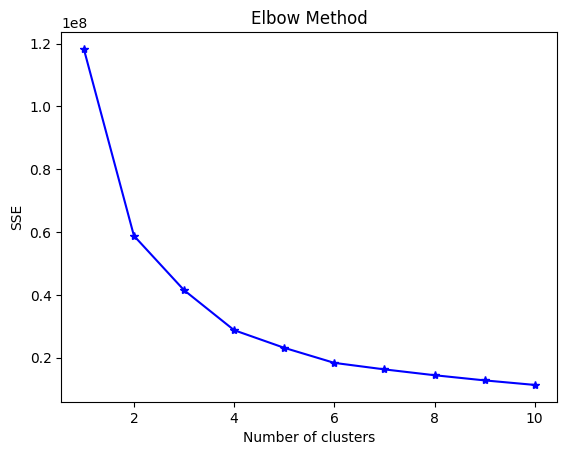

In [ ]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(us_rfm_lean)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
# Build the model using the optimal n_cluster
kmeans = KMeans(n_clusters=4, n_init=20, random_state=1)
# Fit the model and assign each data point to the cluster
y_pred = kmeans.fit_predict(us_rfm_lean) # fit and then predict

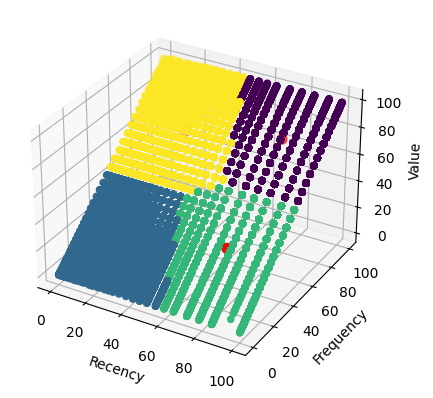

In [ ]:
# 3d plot after kmeans clustering
from mpl_toolkits import mplot3d 
fig = plt.figure(20) 
ax = plt.axes(projection='3d') 
ax.scatter3D(us_rfm_lean['R_rank_norm'], us_rfm_lean['F_rank_norm'], us_rfm_lean['M_rank_norm'], c=y_pred); 
ax.scatter3D(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s=50, c='red') 
ax.set_xlabel('Recency') 
ax.set_ylabel('Frequency') 
ax.set_zlabel('Value') 
plt.show()

We can see that although clustering R, F, and M together could not produce any effective cluster groups, we can still derive that Frequency and Value have very strong linear correlation that results in the scatter pattern that we can observe in this 3-dimension plot. Moving forward, we can safely assume a direct correlation between the afformentioned features.

#### Combine RFM with Customer Information

In [ ]:
#go to customer schema
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "SYSADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": "COMPUTE_WH",
    "schema": "RAW_CUSTOMER"
}

session = Session.builder.configs(connection_parameters).create()

In [ ]:
customer_sdf = session.table('CUSTOMER_LOYALTY')
customer_sdf.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"          |"COUNTRY"  |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                  |"PHONE_NUMBER"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |Rodolfo       |Tucker       |Hamburg         |Germany    |21129          |German                |Female       |NULL               |Single            |0                 |2019-02-19      

In [ ]:
#filter by country
customer_sdf_us = customer_sdf.filter(F.col("COUNTRY") == 'United States')
print(customer_sdf_us.select('COUNTRY').distinct().collect())
print(customer_sdf_us.count())

[Row(COUNTRY='United States')]
46300


In [ ]:
customer_sdf_us = customer_sdf_us.toPandas()
customer_us = us_rfm.merge(customer_sdf_us, on='CUSTOMER_ID', how='left')
print(customer_us.count())
customer_us.head()

CUSTOMER_ID           46300
FREQUENCY             46300
MONETARY_VALUE        46300
Recency               46300
R_rank_norm           46300
F_rank_norm           46300
M_rank_norm           46300
RFM_Score             46300
FIRST_NAME            46300
LAST_NAME             46300
CITY                  46300
COUNTRY               46300
POSTAL_CODE           46291
PREFERRED_LANGUAGE    46300
GENDER                46300
FAVOURITE_BRAND           0
MARITAL_STATUS        46300
CHILDREN_COUNT        46300
SIGN_UP_DATE          46300
BIRTHDAY_DATE         46300
E_MAIL                46300
PHONE_NUMBER          46300
dtype: int64


,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,FIRST_NAME,LAST_NAME,CITY,COUNTRY,POSTAL_CODE,PREFERRED_LANGUAGE,GENDER,FAVOURITE_BRAND,MARITAL_STATUS,CHILDREN_COUNT,SIGN_UP_DATE,BIRTHDAY_DATE,E_MAIL,PHONE_NUMBER
0,87781,46,1795.25,26,10.62,23.23,23.23,1.07,Jaylen,Day,Seattle,United States,98195,English,Male,None,Single,0,2021-01-20,2000-05-30,Jaylen.Day@gmail.com,835-880-2596
1,145829,60,2411.75,6,59.35,68.05,68.05,3.34,Myles,Gates,Seattle,United States,98117,English,Female,None,Married,2,2020-04-03,1956-01-18,Myles.Gates@aol.com,507-452-1834
2,158289,72,2454.50,26,10.62,96.53,96.53,4.18,Issac,Lam,Seattle,United States,98115,English,Female,None,Married,2,2021-12-15,1960-06-15,Issac.Lam@aol.com,039-619-6630
3,151268,67,2678.00,2,85.24,89.18,89.18,4.43,Gianni,Wilkins,Seattle,United States,98109,English,Male,None,Single,0,2021-11-09,1992-12-11,Gianni.Wilkins@gmail.com,506-126-3508
4,150953,68,2392.50,9,45.88,91.14,91.14,4.22,Adyson,Cobb,Seattle,United States,98199,English,Male,None,Single,2,2019-04-04,1957-02-20,Adyson.Cobb@aol.com,003-848-2120


In [ ]:
# #Merging dataframes together
# avg_amt_order = avg_amt_order.toPandas()
# cust_avg_item = cust_avg_item.toPandas()
# cust_freq_cat = cust_freq_cat.toPandas()
# cust_item_profit = cust_item_profit.toPandas()
# average_monthly_spending = average_monthly_spending.toPandas()
# average_monthly_spending.set_index(['CUSTOMER_ID'], inplace=True)

# customer_us = customer_us.merge(avg_amt_order, on='CUSTOMER_ID', how='left')
# customer_us = customer_us.merge(cust_avg_item, on='CUSTOMER_ID', how='left')
# customer_us = customer_us.merge(cust_freq_cat, on='CUSTOMER_ID', how='left')
# customer_us = customer_us.merge(cust_item_profit, on='CUSTOMER_ID', how='left')
# customer_us.set_index(['CUSTOMER_ID'], inplace=True)
# print('Hello')
# customer_us = customer_us.join(average_monthly_spending, on = 'CUSTOMER_ID')

In [ ]:
avg_amt_order = avg_amt_order.toPandas()
cust_avg_item = cust_avg_item.toPandas()
cust_freq_cat = cust_freq_cat.toPandas()
cust_item_profit = cust_item_profit.toPandas()
average_monthly_spending = average_monthly_spending.toPandas()

customer_us = customer_us.join(avg_amt_order.set_index("CUSTOMER_ID"), on='CUSTOMER_ID', how='left')
customer_us = customer_us.join(cust_avg_item.set_index("CUSTOMER_ID"), on='CUSTOMER_ID', how='left')
customer_us = customer_us.join(cust_freq_cat.set_index("CUSTOMER_ID"), on='CUSTOMER_ID', how='left')
customer_us = customer_us.merge(cust_item_profit.set_index("CUSTOMER_ID"), on='CUSTOMER_ID', how='left')
print("Hello")
#customer_us = customer_us.join(cust_item_profit.set_index("CUSTOMER_ID"), on='CUSTOMER_ID', how='left')
customer_us = customer_us.join(average_monthly_spending.set_index("CUSTOMER_ID"), on = 'CUSTOMER_ID', how = 'left')


Hello


In [ ]:
customer_us.head()

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,FIRST_NAME,LAST_NAME,CITY,COUNTRY,POSTAL_CODE,PREFERRED_LANGUAGE,GENDER,FAVOURITE_BRAND,MARITAL_STATUS,CHILDREN_COUNT,SIGN_UP_DATE,BIRTHDAY_DATE,E_MAIL,PHONE_NUMBER,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,MEAN_PROFIT,TOTAL_CUSTOMER_SPENDINGS,AVERAGE_MONTHLY_SPENDING
0,87781,46,1795.25,26,10.62,23.23,23.23,1.07,Jaylen,Day,Seattle,United States,98195,English,Male,None,Single,0,2021-01-20,2000-05-30,Jaylen.Day@gmail.com,835-880-2596,39.0271739130,4.413043,Main,Hot Option,958.10,6.9427536232,7088.0,205.6843218664
1,145829,60,2411.75,6,59.35,68.05,68.05,3.34,Myles,Gates,Seattle,United States,98117,English,Female,None,Married,2,2020-04-03,1956-01-18,Myles.Gates@aol.com,507-452-1834,40.1958333333,4.366667,Main,Warm Option,1275.55,7.1660112360,9090.0,262.2517966340
2,158289,72,2454.50,26,10.62,96.53,96.53,4.18,Issac,Lam,Seattle,United States,98115,English,Female,None,Married,2,2021-12-15,1960-06-15,Issac.Lam@aol.com,039-619-6630,34.0902777778,3.833333,Main,Warm Option,1348.50,7.0602094241,8457.5,235.9052242010
3,151268,67,2678.00,2,85.24,89.18,89.18,4.43,Gianni,Wilkins,Seattle,United States,98109,English,Male,None,Single,0,2021-11-09,1992-12-11,Gianni.Wilkins@gmail.com,506-126-3508,39.9701492537,3.895522,Main,Hot Option,1359.35,7.9031976744,9862.5,267.8163885056
4,150953,68,2392.50,9,45.88,91.14,91.14,4.22,Adyson,Cobb,Seattle,United States,98199,English,Male,None,Single,2,2019-04-04,1957-02-20,Adyson.Cobb@aol.com,003-848-2120,35.1838235294,4.235294,Main,Cold Option,1316.55,6.5827500000,9079.0,257.7096163581


In [ ]:
# drop unneeded columns
customer_us.drop(['FAVOURITE_BRAND'], axis=1, inplace=True)

In [ ]:
customer_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CUSTOMER_ID               46300 non-null  int32  
 1   FREQUENCY                 46300 non-null  int64  
 2   MONETARY_VALUE            46300 non-null  float64
 3   Recency                   46300 non-null  int64  
 4   R_rank_norm               46300 non-null  float64
 5   F_rank_norm               46300 non-null  float64
 6   M_rank_norm               46300 non-null  float64
 7   RFM_Score                 46300 non-null  float64
 8   FIRST_NAME                46300 non-null  object 
 9   LAST_NAME                 46300 non-null  object 
 10  CITY                      46300 non-null  object 
 11  COUNTRY                   46300 non-null  object 
 12  POSTAL_CODE               46291 non-null  object 
 13  PREFERRED_LANGUAGE        46300 non-null  object 
 14  GENDER

In [ ]:
# create time feature
customer_us['BIRTHDAY_DATE'] = pd.to_datetime(customer_us['BIRTHDAY_DATE'])
customer_us['SIGN_UP_DATE'] = pd.to_datetime(customer_us['SIGN_UP_DATE'])
customer_us['AGE'] = (datetime.now() - customer_us['BIRTHDAY_DATE']).astype('<m8[Y]')
customer_us['MEMBER_MONTHS'] = (datetime.now() - customer_us['SIGN_UP_DATE']).astype('<m8[M]')

In [ ]:
customer_us['PREFERRED_LANGUAGE'].unique() # US customers; column unimportant in this context

array(['English'], dtype=object)

In [ ]:
customer_us['GENDER'].unique()

array(['Male', 'Female', 'Undisclosed'], dtype=object)

## Encoding Categorical Variables

In [ ]:
customer_us.replace({'GENDER':
                     {'Female':0,
                      'Male':1,
                      'Undisclosed': 2}}
                      , inplace = True)
customer_us['GENDER'].unique()

array([1, 0, 2])

In [ ]:
customer_us['MARITAL_STATUS'].unique()

array(['Single', 'Married', 'Divorced/Seperated', 'Undisclosed'],
      dtype=object)

In [ ]:
customer_us.replace({'MARITAL_STATUS':
                     {'Single':0,
                      'Married':1,
                      'Divorced/Seperated':2,
                      'Undisclosed':3}}
                      , inplace = True)
customer_us['MARITAL_STATUS'].unique()

array([0, 1, 2, 3])

In [ ]:
customer_us['CHILDREN_COUNT'].unique()

array(['0', '2', '4', '1', '3', 'Undisclosed', '5+'], dtype=object)

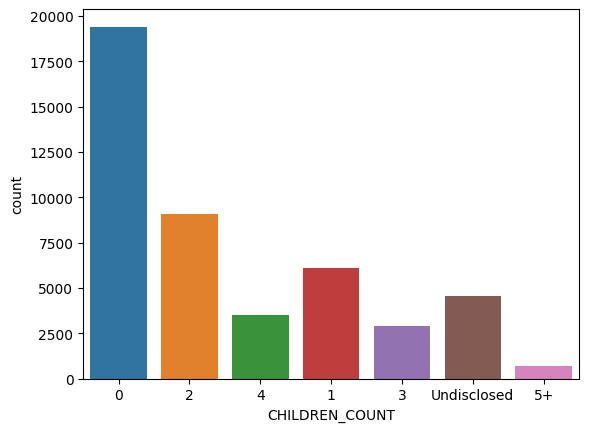

In [ ]:
sns.countplot(x='CHILDREN_COUNT', data=customer_us)
plt.show()

In [ ]:
customer_us.replace({'CHILDREN_COUNT':
                     {'Undisclosed':0,
                      '5+':5}}
                      , inplace=True)
customer_us.CHILDREN_COUNT=pd.to_numeric(customer_us.CHILDREN_COUNT)
customer_us['CHILDREN_COUNT'].unique()

array([0, 2, 4, 1, 3, 5])

In [ ]:
customer_us['FREQ_SUBCAT'].unique()

array(['Hot Option', 'Warm Option', 'Cold Option'], dtype=object)

In [ ]:
customer_us.replace({'FREQ_SUBCAT':
                     {'Cold Option':0,
                      'Warm Option':1,
                      'Hot Option':2}}
                      , inplace=True)
customer_us['FREQ_SUBCAT'].unique()

array([2, 1, 0])

In [ ]:
customer_us['FREQ_CATEGORY'].unique()

array(['Main'], dtype=object)

In [ ]:
customer_us.replace({'FREQ_CATEGORY':
                     {'Main':0}}
                      , inplace=True)

In [ ]:
customer_us['CITY'].unique()

array(['Seattle', 'San Mateo', 'Denver', 'New York City', 'Boston'],
      dtype=object)

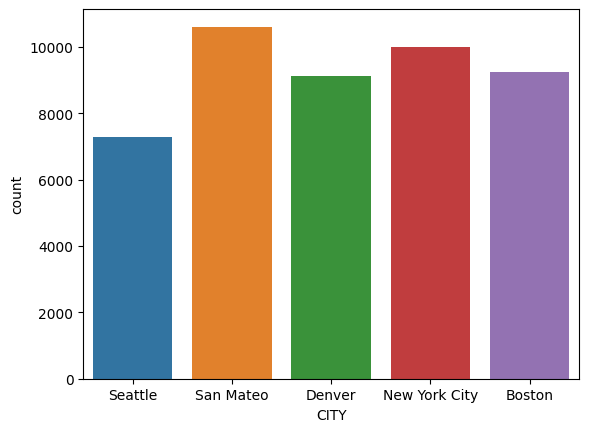

In [ ]:
sns.countplot(x='CITY', data=customer_us)
plt.show()

In [ ]:
#from feature_engine.encoding import OneHotEncoder
#encoder = OneHotEncoder(variables=['CITY'], drop_last = False)
#ohe_customer_us = encoder.fit_transform(customer_us)
replacement_map = {'CITY' :{'Seattle' : 0, 'New York City' : 1, 'Boston' : 2, 'Denver' : 3, 'San Mateo' : 4}}
customer_us.replace(replacement_map, inplace = True)
ohe_customer_us = customer_us

In [ ]:
customer_us.head()

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,FIRST_NAME,LAST_NAME,CITY,COUNTRY,POSTAL_CODE,PREFERRED_LANGUAGE,GENDER,MARITAL_STATUS,CHILDREN_COUNT,SIGN_UP_DATE,BIRTHDAY_DATE,E_MAIL,PHONE_NUMBER,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,MEAN_PROFIT,TOTAL_CUSTOMER_SPENDINGS,AVERAGE_MONTHLY_SPENDING,AGE,MEMBER_MONTHS
0,87781,46,1795.25,26,10.62,23.23,23.23,1.07,Jaylen,Day,0,United States,98195,English,1,0,0,2021-01-20,2000-05-30,Jaylen.Day@gmail.com,835-880-2596,39.0271739130,4.413043,0,2,958.10,6.9427536232,7088.0,205.6843218664,23.0,30.0
1,145829,60,2411.75,6,59.35,68.05,68.05,3.34,Myles,Gates,0,United States,98117,English,0,1,2,2020-04-03,1956-01-18,Myles.Gates@aol.com,507-452-1834,40.1958333333,4.366667,0,1,1275.55,7.1660112360,9090.0,262.2517966340,67.0,39.0
2,158289,72,2454.50,26,10.62,96.53,96.53,4.18,Issac,Lam,0,United States,98115,English,0,1,2,2021-12-15,1960-06-15,Issac.Lam@aol.com,039-619-6630,34.0902777778,3.833333,0,1,1348.50,7.0602094241,8457.5,235.9052242010,63.0,19.0
3,151268,67,2678.00,2,85.24,89.18,89.18,4.43,Gianni,Wilkins,0,United States,98109,English,1,0,0,2021-11-09,1992-12-11,Gianni.Wilkins@gmail.com,506-126-3508,39.9701492537,3.895522,0,2,1359.35,7.9031976744,9862.5,267.8163885056,30.0,20.0
4,150953,68,2392.50,9,45.88,91.14,91.14,4.22,Adyson,Cobb,0,United States,98199,English,1,0,2,2019-04-04,1957-02-20,Adyson.Cobb@aol.com,003-848-2120,35.1838235294,4.235294,0,0,1316.55,6.5827500000,9079.0,257.7096163581,66.0,51.0


In [ ]:
# drop columns
ohe_customer_us.drop(['COUNTRY','PREFERRED_LANGUAGE','FIRST_NAME','LAST_NAME','POSTAL_CODE','SIGN_UP_DATE','BIRTHDAY_DATE','E_MAIL','PHONE_NUMBER', 'TOTAL_CUSTOMER_SPENDINGS'], axis=1, inplace=True)

In [ ]:
ohe_customer_us.head()

,CUSTOMER_ID,FREQUENCY,MONETARY_VALUE,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,CITY,GENDER,MARITAL_STATUS,CHILDREN_COUNT,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,MEAN_PROFIT,AVERAGE_MONTHLY_SPENDING,AGE,MEMBER_MONTHS
0,87781,46,1795.25,26,10.62,23.23,23.23,1.07,0,1,0,0,39.0271739130,4.413043,0,2,958.10,6.9427536232,205.6843218664,23.0,30.0
1,145829,60,2411.75,6,59.35,68.05,68.05,3.34,0,0,1,2,40.1958333333,4.366667,0,1,1275.55,7.1660112360,262.2517966340,67.0,39.0
2,158289,72,2454.50,26,10.62,96.53,96.53,4.18,0,0,1,2,34.0902777778,3.833333,0,1,1348.50,7.0602094241,235.9052242010,63.0,19.0
3,151268,67,2678.00,2,85.24,89.18,89.18,4.43,0,1,0,0,39.9701492537,3.895522,0,2,1359.35,7.9031976744,267.8163885056,30.0,20.0
4,150953,68,2392.50,9,45.88,91.14,91.14,4.22,0,1,0,2,35.1838235294,4.235294,0,0,1316.55,6.5827500000,257.7096163581,66.0,51.0


In [ ]:
ohe_customer_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46300 entries, 0 to 46299
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CUSTOMER_ID               46300 non-null  int32  
 1   FREQUENCY                 46300 non-null  int64  
 2   MONETARY_VALUE            46300 non-null  float64
 3   Recency                   46300 non-null  int64  
 4   R_rank_norm               46300 non-null  float64
 5   F_rank_norm               46300 non-null  float64
 6   M_rank_norm               46300 non-null  float64
 7   RFM_Score                 46300 non-null  float64
 8   CITY                      46300 non-null  int64  
 9   GENDER                    46300 non-null  int64  
 10  MARITAL_STATUS            46300 non-null  int64  
 11  CHILDREN_COUNT            46300 non-null  int64  
 12  AVG_AMT                   46300 non-null  object 
 13  AVG_QUANTITY              46300 non-null  object 
 14  FREQ_C

In [ ]:
ohe_customer_us['AVG_AMT'] = pd.to_numeric(ohe_customer_us['AVG_AMT'])
ohe_customer_us['AVG_QUANTITY'] = pd.to_numeric(ohe_customer_us['AVG_QUANTITY'])
ohe_customer_us['AVERAGE_MONTHLY_SPENDING'] = pd.to_numeric(ohe_customer_us['AVERAGE_MONTHLY_SPENDING'])

Text(0.5, 1.0, 'Results Correlation Heatmap')

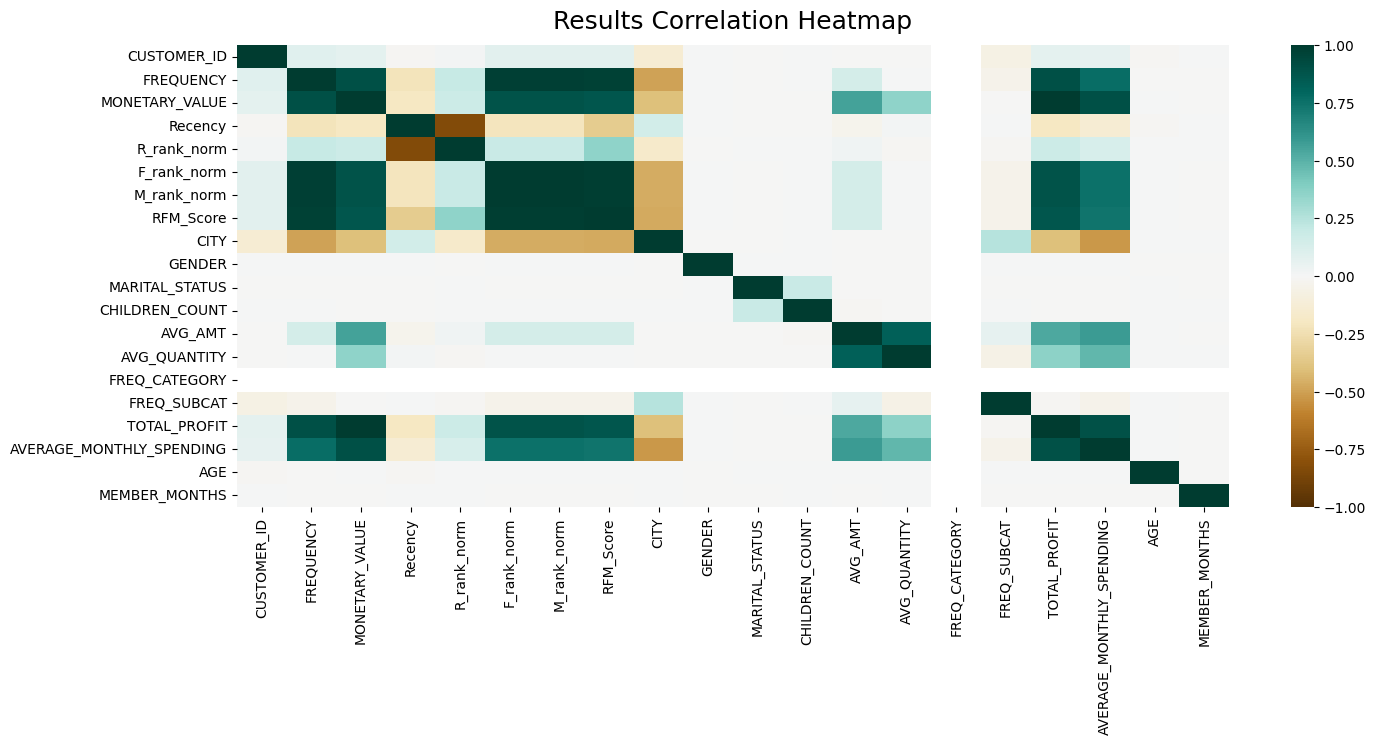

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(ohe_customer_us.corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Results Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [ ]:
# remove columns with too high of a correlation with target (Total Profit)
ohe_customer_us.drop(['MONETARY_VALUE','R_rank_norm','F_rank_norm','M_rank_norm','RFM_Score','FREQUENCY'], axis=1, inplace=True)

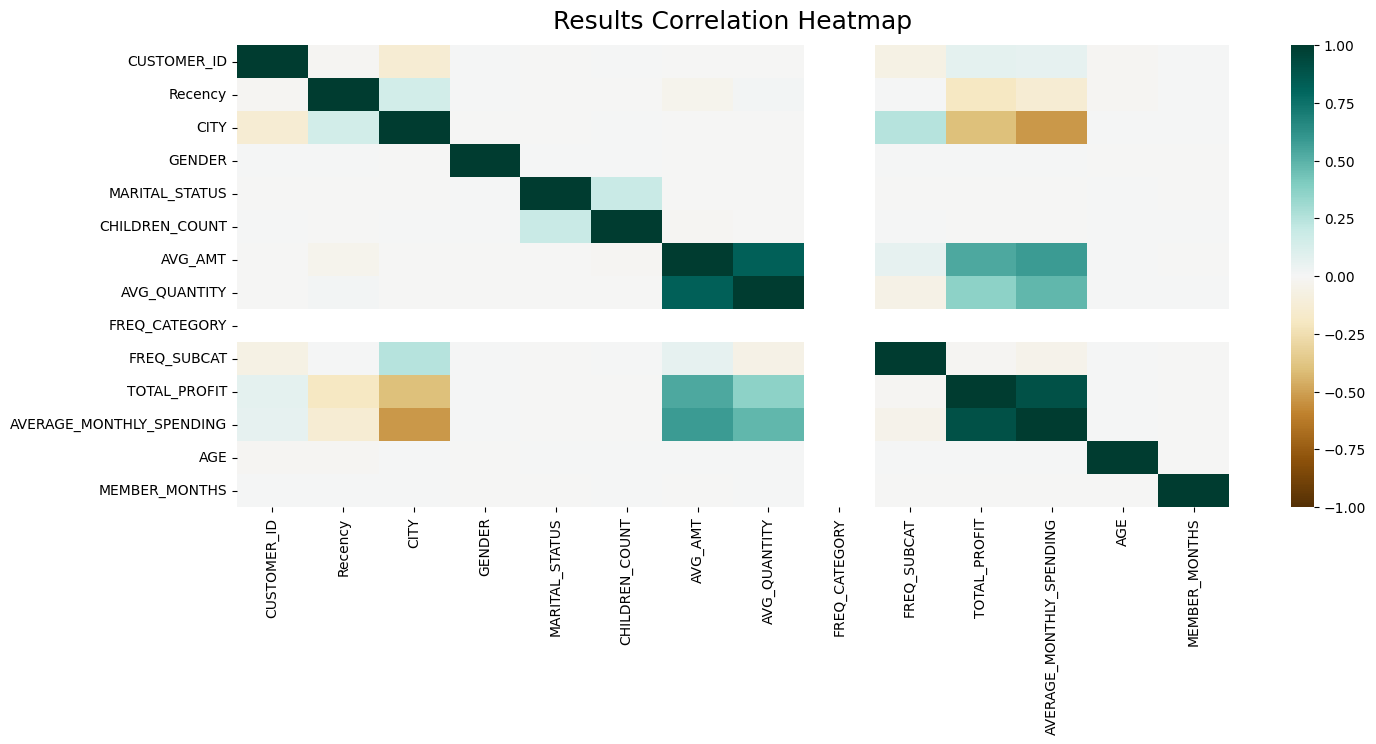

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(ohe_customer_us.corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Results Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

In [ ]:
# get top 20% of customers and classify as "high spender"
ohe_customer_us['SPEND_RANK'] = ohe_customer_us['AVERAGE_MONTHLY_SPENDING'].rank(pct=True)

In [ ]:
ohe_customer_us['SPEND_RANK'] = np.where(ohe_customer_us['SPEND_RANK'] > 0.8, 1, ohe_customer_us['SPEND_RANK'])
ohe_customer_us['SPEND_RANK'] = np.where(ohe_customer_us['SPEND_RANK'] < 1, 0, ohe_customer_us['SPEND_RANK'])

In [ ]:
ohe_customer_us.to_csv('ICP_data.csv')

### Hold Out Dataset and TT split

In [ ]:
ohe_customer_us.describe()

,CUSTOMER_ID,Recency,CITY,GENDER,MARITAL_STATUS,CHILDREN_COUNT,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,AVERAGE_MONTHLY_SPENDING,AGE,MEMBER_MONTHS,SPEND_RANK
count,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000,46300.0,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000,46300.000000
mean,110518.969028,11.411944,2.124320,0.643758,0.899028,1.093952,38.506258,4.148999,0.0,1.863715,1098.432772,209.834021,50.031274,33.525378,0.200000
std,52901.778359,12.417235,1.394438,0.664083,0.942767,1.373894,4.126962,0.412109,0.0,0.433037,260.199303,59.580703,19.221474,12.101910,0.400004
min,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.428571,2.400000,0.0,0.000000,276.000000,29.174405,17.000000,13.000000,0.000000
25%,67634.750000,3.000000,1.000000,0.000000,0.000000,0.000000,35.702077,3.868852,0.0,2.000000,916.050000,169.051661,33.000000,23.000000,0.000000
50%,111792.500000,8.000000,2.000000,1.000000,1.000000,0.000000,38.444444,4.138889,0.0,2.000000,1110.350000,213.530666,50.000000,34.000000,0.000000
75%,155843.000000,15.000000,3.000000,1.000000,1.000000,2.000000,41.221408,4.418182,0.0,2.000000,1278.812500,250.773461,67.000000,44.000000,0.000000
max,200000.000000,146.000000,4.000000,2.000000,3.000000,5.000000,58.405660,6.320000,0.0,2.000000,2178.700000,459.000924,83.000000,54.000000,1.000000


In [ ]:
ohe_customer_us.median()

CUSTOMER_ID                 111792.500000
Recency                          8.000000
CITY                             2.000000
GENDER                           1.000000
MARITAL_STATUS                   1.000000
CHILDREN_COUNT                   0.000000
AVG_AMT                         38.444444
AVG_QUANTITY                     4.138889
FREQ_CATEGORY                    0.000000
FREQ_SUBCAT                      2.000000
TOTAL_PROFIT                  1110.350000
MEAN_PROFIT                      7.364267
AVERAGE_MONTHLY_SPENDING       213.530666
AGE                             50.000000
MEMBER_MONTHS                   34.000000
SPEND_RANK                       0.000000
dtype: float64

In [ ]:
holdout_customer_us = ohe_customer_us.sample(frac=0.2) #creating holdout dataset
rest_customer_us = ohe_customer_us.drop(holdout_customer_us.index)
print(len(holdout_customer_us))
print(len(rest_customer_us))

9260
37040


In [ ]:
rest_customer_us['SPEND_RANK'].value_counts()

0.0    29615
1.0     7425
Name: SPEND_RANK, dtype: int64

In [ ]:
#stratified sampling
df1=rest_customer_us[rest_customer_us['SPEND_RANK']==1] #all 1s
df0=rest_customer_us[rest_customer_us['SPEND_RANK']==0] #all 0s
df0_sampled = df0.sample(n=len(df1), random_state=22).copy()
rest_customer_us=pd.concat([df1,df0_sampled],axis=0)
rest_customer_us['SPEND_RANK'].value_counts()

1.0    7425
0.0    7425
Name: SPEND_RANK, dtype: int64

In [ ]:
# TT split
X = rest_customer_us.drop(['AVERAGE_MONTHLY_SPENDING','SPEND_RANK'], axis=1)
y = rest_customer_us['SPEND_RANK']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [ ]:
# normalization
X_train_before = X_train.copy()
X_test_before = X_test.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=X_train_before.index, columns=X_train_before.columns)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, index=X_test_before.index, columns=X_train_before.columns)

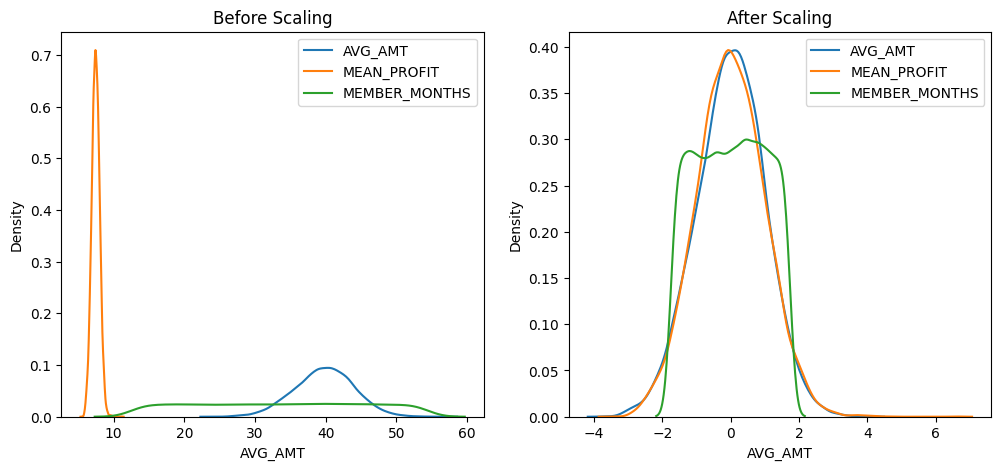

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train_before['AVG_AMT'], ax=ax1, label ='AVG_AMT')
sns.kdeplot(X_train_before['MEAN_PROFIT'], ax=ax1, label ='MEAN_PROFIT')
sns.kdeplot(X_train_before['MEMBER_MONTHS'], ax=ax1, label ='MEMBER_MONTHS')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train['AVG_AMT'], ax=ax2, label ='AVG_AMT')
sns.kdeplot(X_train['MEAN_PROFIT'], ax=ax2, label ='MEAN_PROFIT')
sns.kdeplot(X_train['MEMBER_MONTHS'], ax=ax2, label ='MEMBER_MONTHS')
ax2.legend()
plt.show()

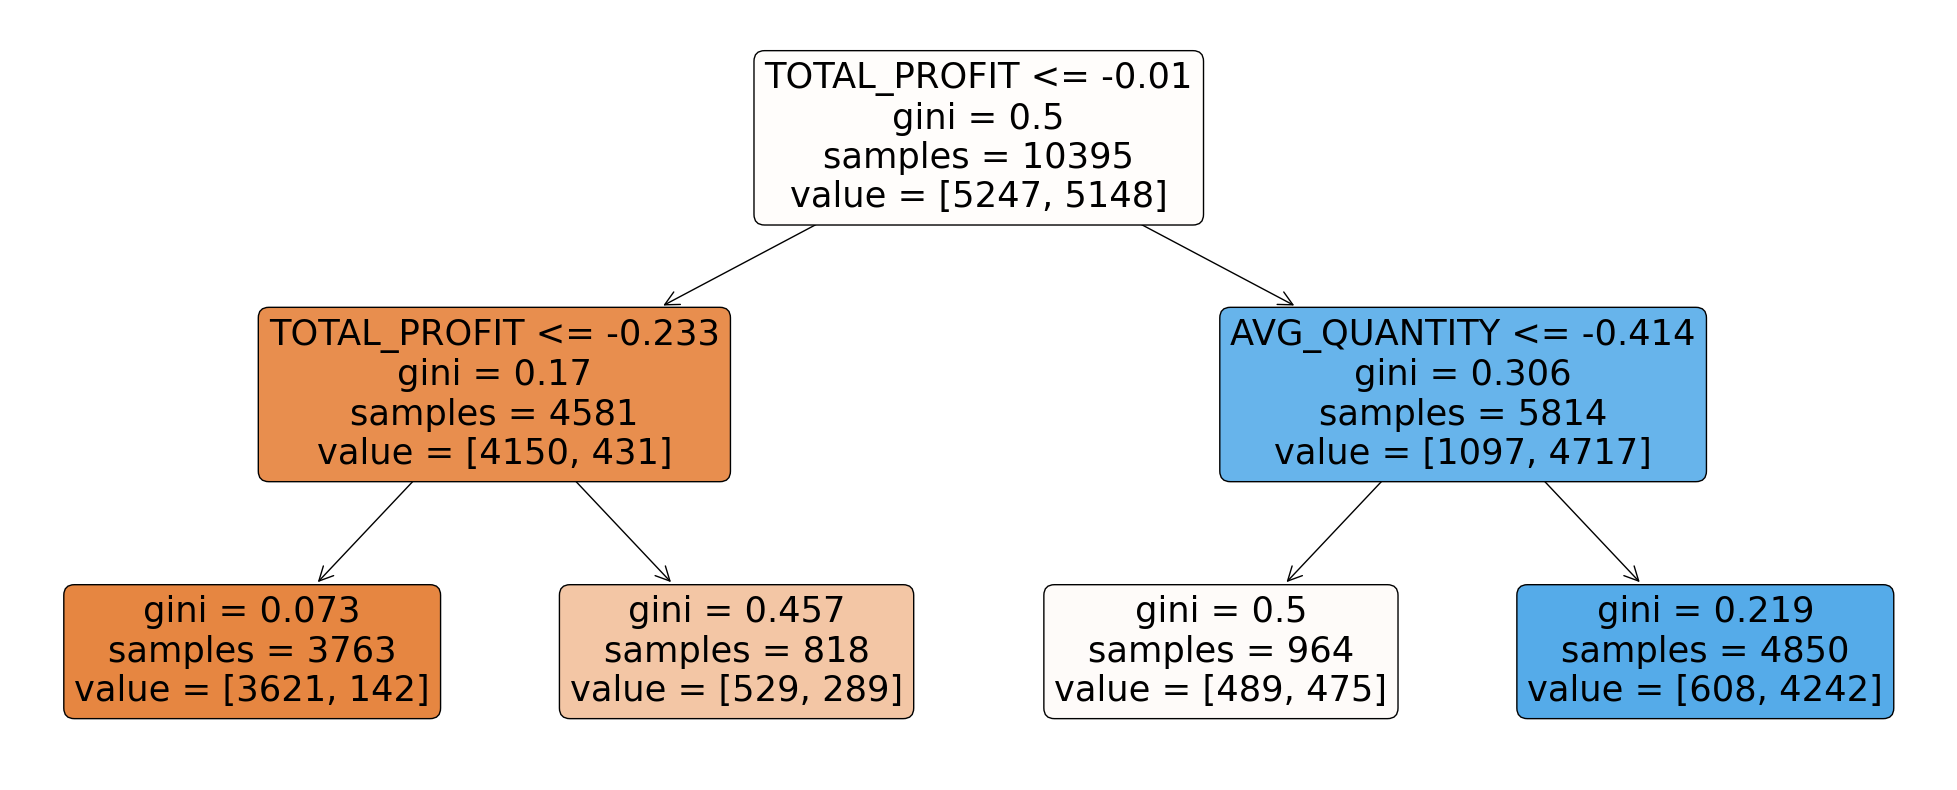

the training accuracy is:  0.8543530543530543
the testing accuracy is:  0.8419753086419753


In [ ]:
tree_class = tree.DecisionTreeClassifier(max_depth=2,random_state=22)
tree_class.fit(X_train, y_train)

plt.figure(figsize=(25,10))
tree.plot_tree(tree_class,
              feature_names = list(rest_customer_us.drop(['AVERAGE_MONTHLY_SPENDING','SPEND_RANK'], axis=1)),
                rounded = True,
                filled= True)
plt.show()

train_acc = tree_class.score(X_train, y_train)
print('the training accuracy is: ', train_acc)
test_acc = tree_class.score(X_test, y_test)
print('the testing accuracy is: ', test_acc)

In [ ]:
#hyper param tuning
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16, 32, 64, 128], 'max_depth' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) # 

print(gs.best_score_)
print(gs.best_params_)

0.8978343636632855
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 64}


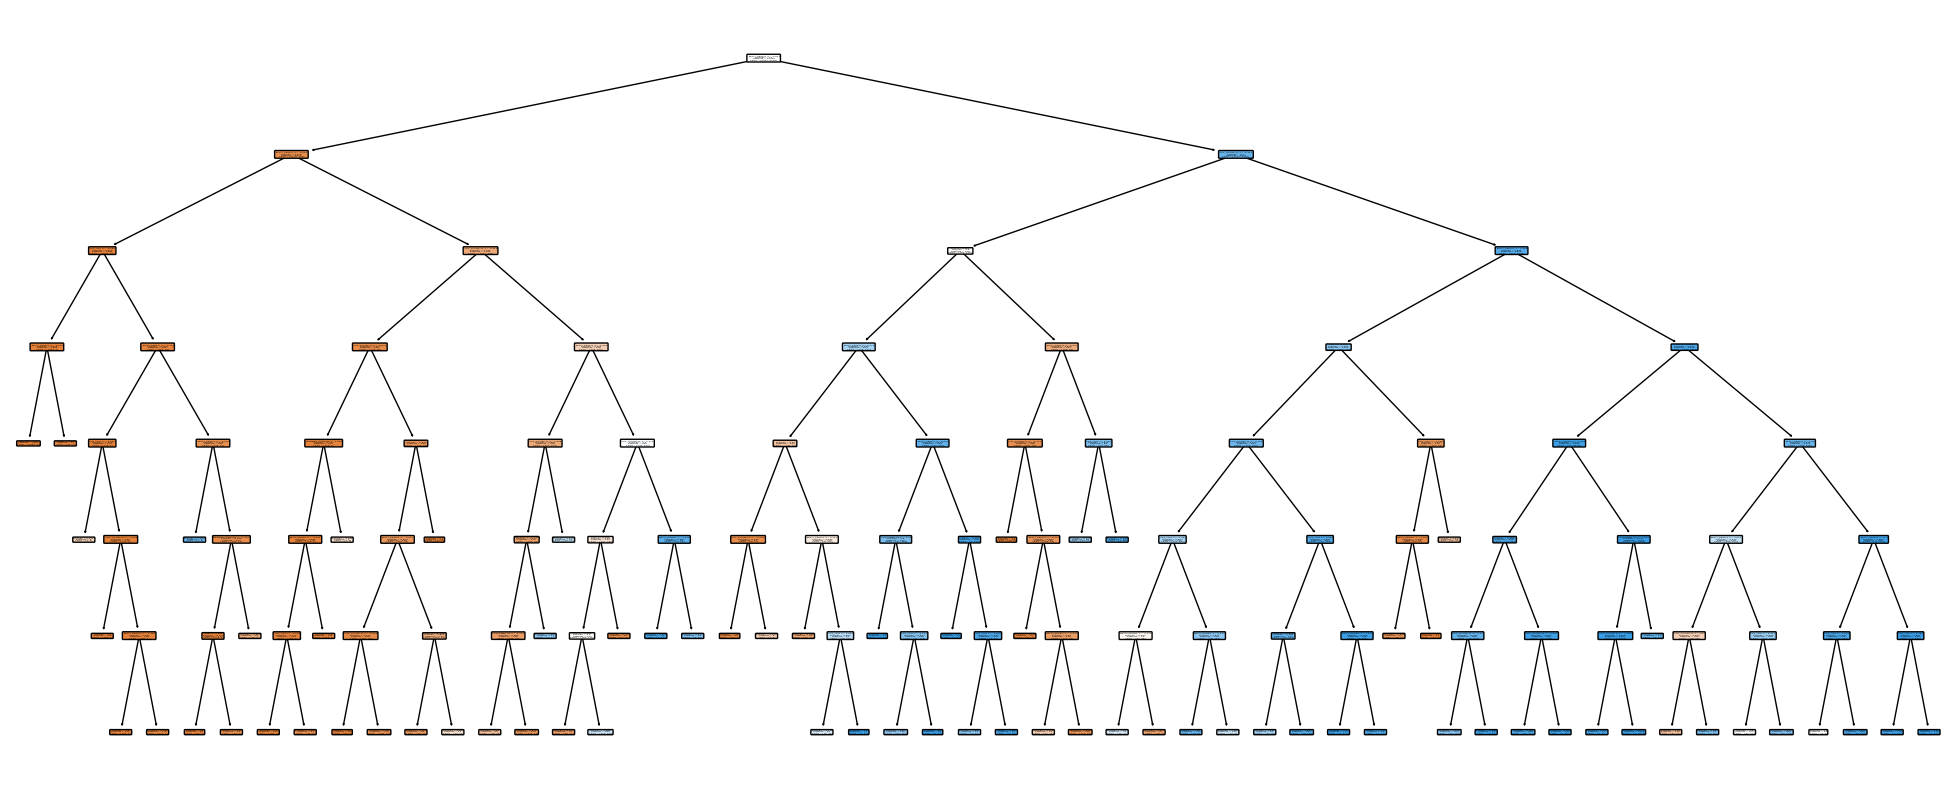

the training accuracy is:  0.9088023088023088
the testing accuracy is:  0.8933782267115601


In [ ]:
tree_class = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=5, min_samples_split=64, max_depth=7,random_state=22)
tree_class.fit(X_train, y_train)

plt.figure(figsize=(25,10))
tree.plot_tree(tree_class,
              feature_names = list(rest_customer_us.drop(['AVERAGE_MONTHLY_SPENDING','SPEND_RANK'], axis=1)),
                rounded = True,
                filled= True)
plt.show()

train_acc = tree_class.score(X_train, y_train)
print('the training accuracy is: ', train_acc)
test_acc = tree_class.score(X_test, y_test)
print('the testing accuracy is: ', test_acc)

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['feature']), 
           pd.DataFrame(tree_class.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,feature,importance
10,TOTAL_PROFIT,0.762712
7,AVG_QUANTITY,0.116561
2,CITY,0.082132
6,AVG_AMT,0.020736
11,MEAN_PROFIT,0.006749
0,CUSTOMER_ID,0.004739
13,MEMBER_MONTHS,0.003089
1,Recency,0.001760
12,AGE,0.001522
3,GENDER,0.000000


### Data Mining first 3 transactions of holdout customers

In [ ]:
avg_item.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TOTAL_QUANTITY"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|122555127   |2                 |279         |10669.0        |NULL           |NULL           |286

In [ ]:
avg_item2 = avg_item.select("ORDER_ID","TOTAL_QUANTITY","CUSTOMER_ID","ORDER_TS")
avg_item2 = avg_item2.na.drop(subset=["CUSTOMER_ID"])

In [ ]:
# get first 3 transaction of each customer
avg_item_window = Window.partitionBy("CUSTOMER_ID").orderBy(F.col("ORDER_TS").asc())
avg_item_rowed = avg_item2.withColumn("row",F.row_number().over(avg_item_window))

avg_item_rowed=avg_item_rowed.filter(F.col("row") <= 3)
avg_item_rowed=avg_item_rowed.drop('row')

# agg
first3_avg_item = avg_item_rowed.groupBy(['CUSTOMER_ID']).agg([F.avg('TOTAL_QUANTITY').as_('AVG_QUANTITY')])

In [ ]:
first3_avg_item.show()

----------------------------------
|"CUSTOMER_ID"  |"AVG_QUANTITY"  |
----------------------------------
|135234         |3.333333        |
|151991         |6.333333        |
|27861          |5.000000        |
|12489          |3.666667        |
|170804         |4.000000        |
|66732          |2.333333        |
|12541          |7.000000        |
|213257         |4.666667        |
|138475         |4.666667        |
|81384          |4.000000        |
----------------------------------



In [ ]:
avg_amt_order2 = order_location_sdf_usa.select("ORDER_ID","ORDER_AMOUNT","CUSTOMER_ID","ORDER_TS")
avg_amt_order2 = avg_amt_order2.na.drop(subset=["CUSTOMER_ID"])

avg_amt_rowed = avg_amt_order2.withColumn("row",F.row_number().over(avg_item_window))
avg_amt_rowed=avg_amt_rowed.filter(F.col("row") <= 3)
avg_amt_rowed=avg_amt_rowed.drop('row')

first3_avg_amt_order = avg_amt_rowed.groupBy("CUSTOMER_ID").agg([F.mean('ORDER_AMOUNT').alias('avg_amt')])
first3_avg_amt_order.show()

---------------------------------
|"CUSTOMER_ID"  |"AVG_AMT"      |
---------------------------------
|163472         |22.6666666667  |
|86091          |47.6666666667  |
|82937          |18.0000000000  |
|160083         |16.0000000000  |
|134270         |19.8333333333  |
|164926         |40.0000000000  |
|187090         |32.5000000000  |
|86704          |22.8333333333  |
|198932         |15.6666666667  |
|151765         |28.6666666667  |
---------------------------------



In [ ]:
cust_order_freq_cat2 = cust_order_freq_cat.select("ORDER_ID","FREQ_CATEGORY","FREQ_SUBCAT","CUSTOMER_ID","ORDER_TS")
cust_order_freq_cat2 = cust_order_freq_cat2.na.drop(subset=["CUSTOMER_ID"])

cust_cat_rowed = cust_order_freq_cat2.withColumn("row",F.row_number().over(avg_item_window))
cust_cat_rowed=cust_cat_rowed.filter(F.col("row") <= 3)
cust_cat_rowed=cust_cat_rowed.drop('row')

first3_cust_freq_cat = cust_cat_rowed.groupBy(["CUSTOMER_ID"]).agg([F.mode('FREQ_CATEGORY').alias('FREQ_CATEGORY'),
                                                       F.mode('FREQ_SUBCAT').alias('FREQ_SUBCAT')])
first3_cust_freq_cat.show()

---------------------------------------------------
|"CUSTOMER_ID"  |"FREQ_CATEGORY"  |"FREQ_SUBCAT"  |
---------------------------------------------------
|65141          |Snack            |Warm Option    |
|21975          |Main             |Hot Option     |
|163245         |Main             |Warm Option    |
|141411         |Main             |Cold Option    |
|173025         |Main             |Hot Option     |
|198029         |Main             |Warm Option    |
|13069          |Beverage         |Hot Option     |
|14378          |Main             |Cold Option    |
|190418         |Main             |Warm Option    |
|190431         |Main             |Cold Option    |
---------------------------------------------------



In [ ]:
cust_item_profit2  = item_profit.join(order_header_sdf, "ORDER_ID")
cust_item_profit2 = cust_item_profit2.select("ORDER_ID","ITEM_PROFIT_TOTAL","CUSTOMER_ID","ORDER_TS")
cust_item_profit2 = cust_item_profit2.na.drop(subset=["CUSTOMER_ID"])

cust_profit_rowed = cust_item_profit2.withColumn("row",F.row_number().over(avg_item_window))
cust_profit_rowed=cust_profit_rowed.filter(F.col("row") <= 3)
cust_profit_rowed=cust_profit_rowed.drop('row')


first3_cust_item_profit = cust_profit_rowed.groupBy(["CUSTOMER_ID"]).agg([F.sum('ITEM_PROFIT_TOTAL').alias('TOTAL_PROFIT'),
                                                                F.mean('ITEM_PROFIT_TOTAL').alias('MEAN_PROFIT')])
first3_cust_item_profit.show()

--------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_PROFIT"  |"MEAN_PROFIT"  |
--------------------------------------------------
|33724          |25.0000         |8.3333333333   |
|99292          |20.0000         |6.6666666667   |
|188269         |26.0000         |8.6666666667   |
|99160          |20.2500         |6.7500000000   |
|118736         |13.5000         |4.5000000000   |
|3897           |15.7500         |5.2500000000   |
|74257          |14.5000         |4.8333333333   |
|6419           |17.7500         |5.9166666667   |
|60767          |19.5000         |6.5000000000   |
|151741         |19.2500         |6.4166666667   |
--------------------------------------------------



In [ ]:
holdout_first3 = holdout_customer_us.drop(["Recency","AVG_AMT","AVG_QUANTITY","FREQ_CATEGORY","FREQ_SUBCAT","TOTAL_PROFIT","MEAN_PROFIT","MEMBER_MONTHS"], axis=1)

In [ ]:
first3_avg_amt_order = first3_avg_amt_order.toPandas()
first3_cust_avg_item = first3_avg_item.toPandas()
first3_cust_freq_cat = first3_cust_freq_cat.toPandas()
first3_cust_item_profit = first3_cust_item_profit.toPandas()

holdout_first3 = holdout_first3.merge(first3_avg_amt_order, on='CUSTOMER_ID', how='left')
holdout_first3 = holdout_first3.merge(first3_cust_avg_item, on='CUSTOMER_ID', how='left')
holdout_first3 = holdout_first3.merge(first3_cust_freq_cat, on='CUSTOMER_ID', how='left')
holdout_first3 = holdout_first3.merge(first3_cust_item_profit, on='CUSTOMER_ID', how='left')

In [ ]:
holdout_first3.head()

,CUSTOMER_ID,CITY,GENDER,MARITAL_STATUS,CHILDREN_COUNT,AVERAGE_MONTHLY_SPENDING,AGE,SPEND_RANK,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,MEAN_PROFIT
0,126783,4,1,1,3,196.375254,29.0,0.0,35.0000000000,5.000000,Main,Hot Option,14.1,4.7000000000
1,176950,4,2,1,2,157.495214,63.0,0.0,14.8333333333,3.666667,Dessert,Cold Option,8.0,2.6666666667
2,163191,2,1,0,0,267.788279,65.0,1.0,39.8333333333,6.666667,Main,Hot Option,22.8,7.6000000000
3,77723,4,2,0,1,106.143016,45.0,0.0,11.3333333333,2.333333,Dessert,Cold Option,13.4,4.4666666667
4,173958,3,0,0,0,255.956562,47.0,0.0,59.0000000000,8.666667,Main,Hot Option,17.5,5.8333333333


In [ ]:
holdout_first3.replace({'FREQ_SUBCAT':
                     {'Cold Option':0,
                      'Warm Option':1,
                      'Hot Option':2}}
                      , inplace=True)
holdout_first3['FREQ_SUBCAT'].unique()

array([2, 0, 1])

In [ ]:
holdout_first3.replace({'FREQ_CATEGORY':
                     {'Main':0,
                      'Snack':1,
                      'Dessert':2,
                      'Beverage':3}}
                      , inplace=True)
holdout_first3['FREQ_CATEGORY'].unique()

array([0, 2, 1, 3])

### Re-train model
The holdout dataset was tested by data mining only the first 3 transactions of the customers identified in the holdout dataset.

Due to the limitations of this testing style, we are unable to use timesensitive data.

In [ ]:
rest_customer_us.to_csv('rest_customer_us.csv')

In [ ]:
X_train.drop(["Recency","MEMBER_MONTHS","CUSTOMER_ID", "TOTAL_PROFIT"],axis=1,inplace=True)
X_test.drop(["Recency","MEMBER_MONTHS","CUSTOMER_ID", "TOTAL_PROFIT"],axis=1,inplace=True)

In [ ]:
holdout_first3.drop(["AVERAGE_MONTHLY_SPENDING","CUSTOMER_ID"],axis=1,inplace=True)

In [ ]:
holdout_first3.to_csv('holdout_first3.csv')

In [ ]:
#Doing normalization one more time before model retraining
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
#hyper param tuning
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16, 32, 64, 128], 'max_depth' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

0.8124094913748425
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


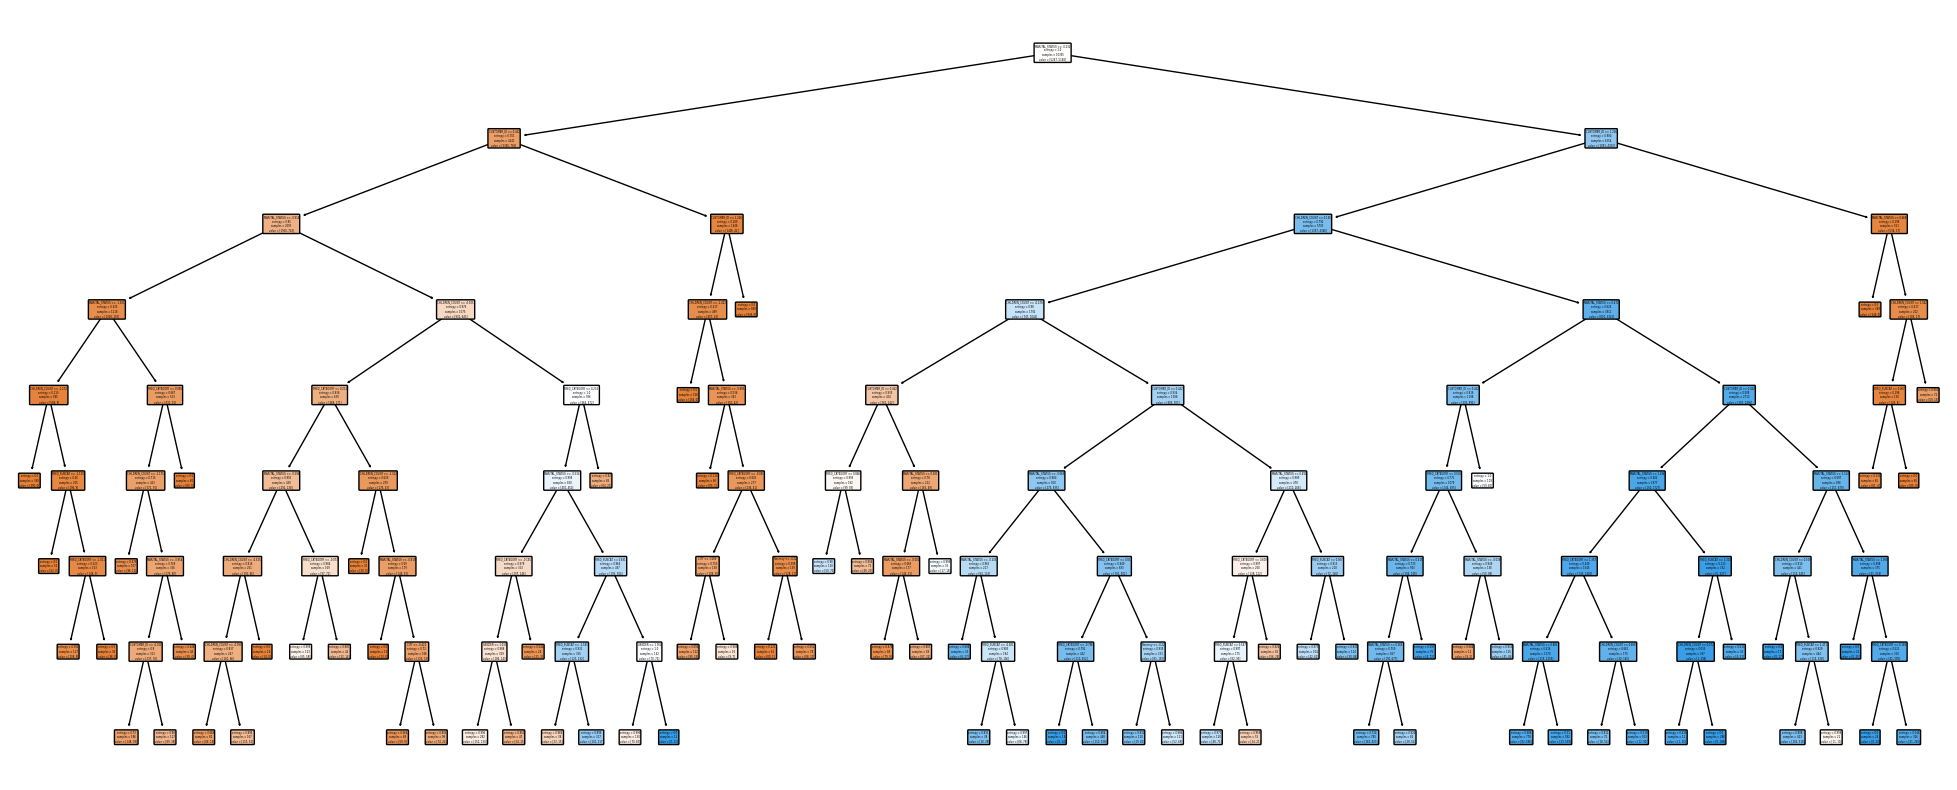

the training accuracy is:  0.8228956228956229
the testing accuracy is:  0.7975308641975308


In [ ]:
tree_class = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=10, min_samples_split=128, max_depth=8,random_state=22)
tree_class.fit(X_train, y_train)

plt.figure(figsize=(25,10))
tree.plot_tree(tree_class,
              feature_names = list(rest_customer_us.drop(['AVERAGE_MONTHLY_SPENDING','SPEND_RANK'], axis=1)),
                rounded = True,
                filled= True)
plt.show()

train_acc = tree_class.score(X_train, y_train)
print('the training accuracy is: ', train_acc)
test_acc = tree_class.score(X_test, y_test)
print('the testing accuracy is: ', test_acc)

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['feature']), 
           pd.DataFrame(tree_class.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,feature,importance
4,AVG_AMT,0.542099
0,CITY,0.298836
5,AVG_QUANTITY,0.115633
8,MEAN_PROFIT,0.026025
9,AGE,0.010594
3,CHILDREN_COUNT,0.003511
1,GENDER,0.002124
2,MARITAL_STATUS,0.001179
6,FREQ_CATEGORY,0.000000
7,FREQ_SUBCAT,0.000000


### Prepare Holdout Dataset
Perform spliting of X-predictor and Y-Target_Var, and Scaling of X

In [ ]:
X_first3 = holdout_first3.drop(['SPEND_RANK'], axis=1)
y_first3 = holdout_first3['SPEND_RANK']

In [ ]:
X_first3.head()

,CITY,GENDER,MARITAL_STATUS,CHILDREN_COUNT,AGE,AVG_AMT,AVG_QUANTITY,FREQ_CATEGORY,FREQ_SUBCAT,TOTAL_PROFIT,MEAN_PROFIT
0,4,1,1,3,29.0,35.0000000000,5.000000,0,2,14.1,4.7000000000
1,4,2,1,2,63.0,14.8333333333,3.666667,2,0,8.0,2.6666666667
2,2,1,0,0,65.0,39.8333333333,6.666667,0,2,22.8,7.6000000000
3,4,2,0,1,45.0,11.3333333333,2.333333,2,0,13.4,4.4666666667
4,3,0,0,0,47.0,59.0000000000,8.666667,0,2,17.5,5.8333333333


In [ ]:
# scaling holdout
X_first3_before = X_first3.copy()
X_first3 = scaler.fit_transform(X_first3)
X_first3 = pd.DataFrame(X_first3, index=X_first3_before.index, columns=X_first3_before.columns)

In [ ]:
# reorder holdout for modelling
X_first3 = X_first3.reindex(columns=list(X_train.columns))

In [ ]:
first3_holdout_acc = tree_class.score(X_first3, y_first3)
print('the holdout accuracy is: ', first3_holdout_acc)

the holdout accuracy is:  0.6042116630669546


# Save the model

In [ ]:
import pickle
pickle.dump(tree_class, open('model.pkl', 'wb'))

In [ ]:
pickle.dump(scaler1, open('scaler.pkl', 'wb'))